### Recreating Horizon Finding Method from "A Hierachical Horizon Detection Algorithm" by Yu-Fei Shen et al.

Eric Graves
Started June 5, 2019

### Notes:
- cv.Canny():
    - filters with GuassianBlur, kernal size = 5x5
    - has hysteresis buit-in (label pixels as strong or weak and remove weak)


(853, 1280)


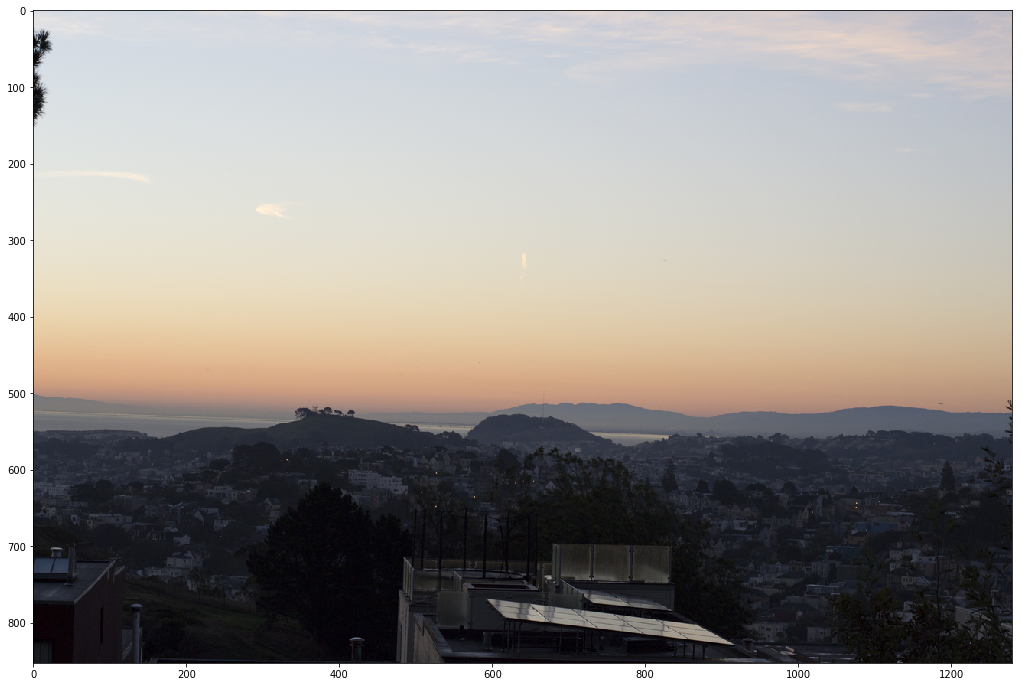

In [1]:
# Imports and environment setup
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
%matplotlib inline

img = cv.imread('image6.png', 0) # grayscale image
img_BGR = cv.imread('image6.png') # read as BGR by default
h,w = img.shape[:2]
print(img.shape)
plt.figure(figsize = (24,12))
img_RGB = cv.cvtColor(img_BGR, cv.COLOR_BGR2RGB) # convert to RGB for cv2 imshow
plt.imshow(img_RGB)
plt.show()

In [2]:
img = cv.imread('image6.png',0)
# Blur with low pass filter: 
#-- Gaussian sigma = num_rows / 50
rows,cols = img.shape[:2]

ksize = 7 # must be an odd value
img_bl = cv.bilateralFilter(img,ksize,175,75) # bilateral method is slow but the best at keeping edges

# plt.figure(figsize = (12,36))
# plt.subplot(611),plt.imshow(img,cmap='gray')
# plt.subplot(612),plt.imshow(img_bl,cmap='gray')

# Canny edge detector
#-- Keep egdes with stregth > 5/num_cols


(<matplotlib.axes._subplots.AxesSubplot at 0x1ff19c36630>,
 <matplotlib.image.AxesImage at 0x1ff19ccd400>)

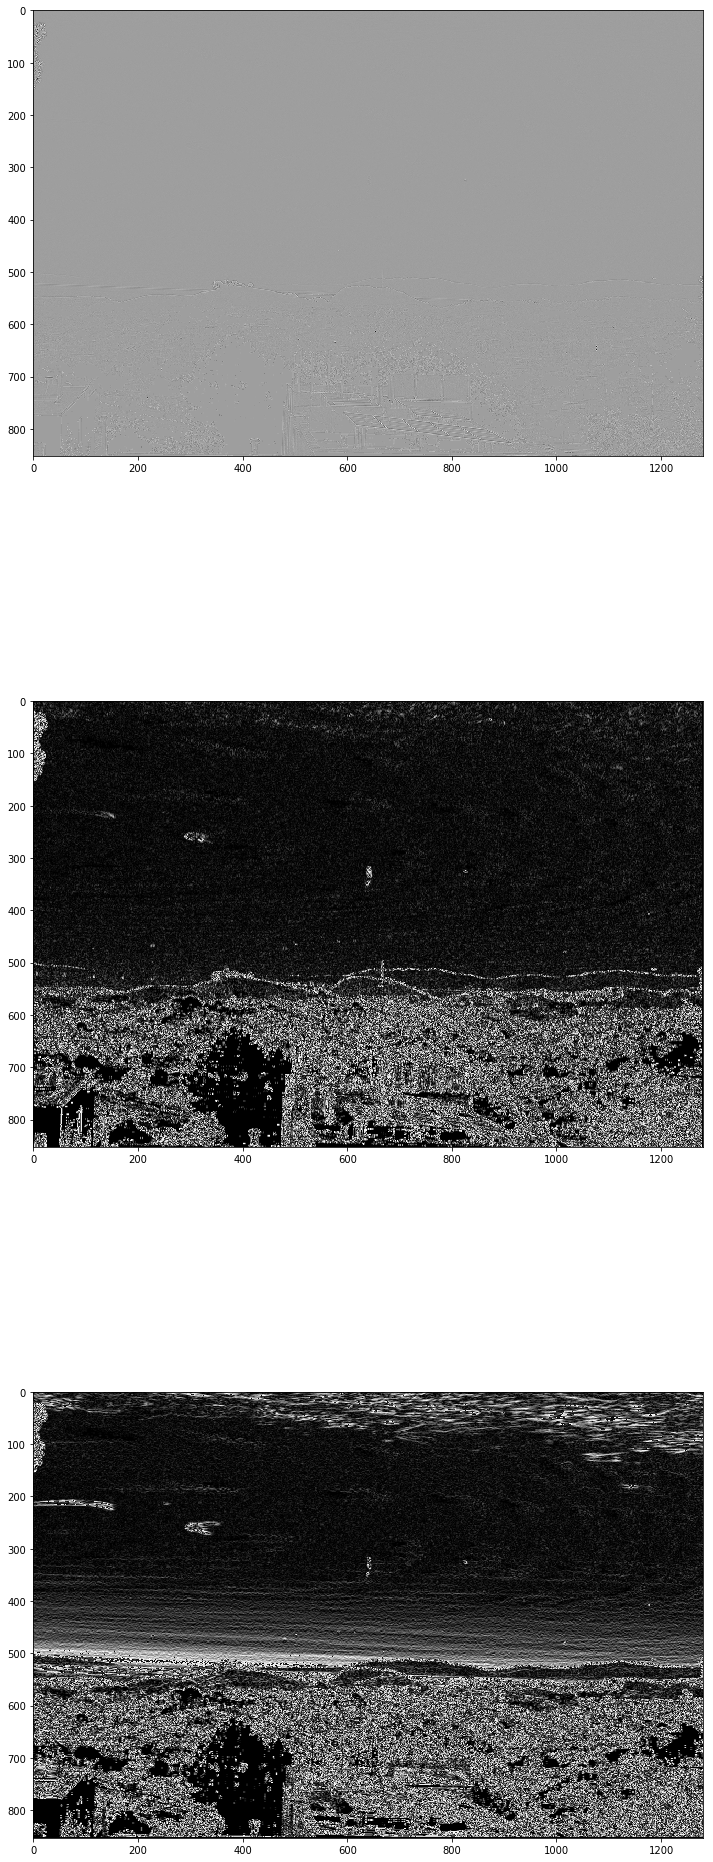

In [3]:
# Other edge detction methods
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)

# convert to b/w for display
abs_sobelx = np.absolute(sobelx)
sobelx_8u = np.uint8(abs_sobelx)
abs_sobely = np.absolute(sobely)
sobely_8u = np.uint8(abs_sobely)


plt.figure(figsize = (12,36))
plt.subplot(311),plt.imshow(laplacian,cmap='gray') 
plt.subplot(312),plt.imshow(sobelx_8u,cmap='gray') 
plt.subplot(313),plt.imshow(sobely_8u,cmap='gray') 

17 1


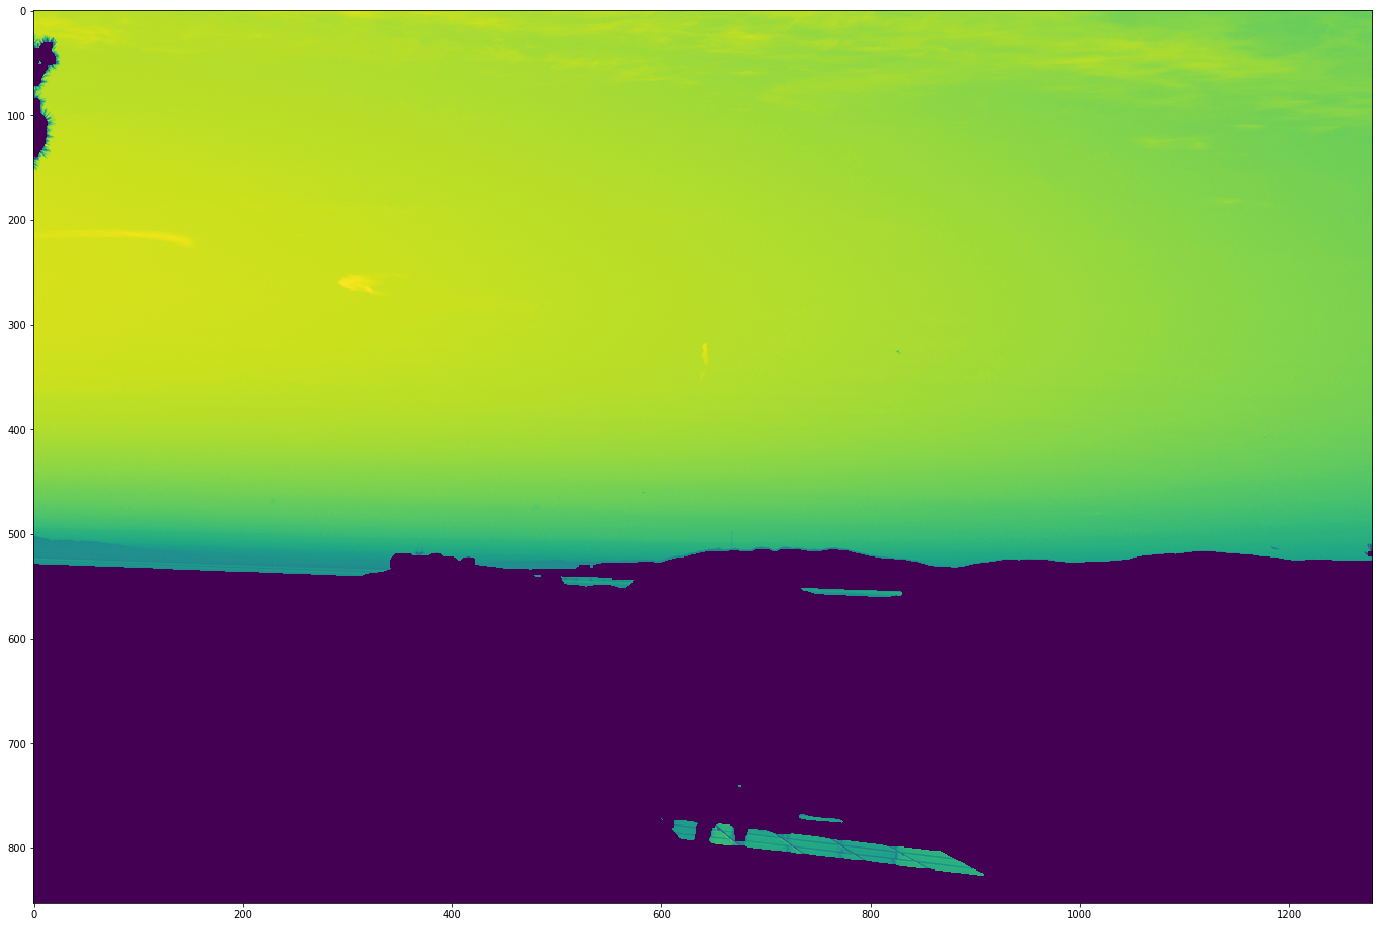

In [4]:

# use Otsu's method to calculate thresholds
high_otsu, img_thresh = cv.threshold(img_bl, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
low_otsu = 0.5*high_otsu

# morphological transforms to remove noise (hopefully)
# -- Need to decide what kernal shape is best for horizon finding
kernel = np.ones((3,5),np.uint8)
opening = cv.morphologyEx(img_thresh,cv.MORPH_OPEN,kernel, iterations = 2) # erosion followed by dialation
closing = cv.morphologyEx(img_thresh,cv.MORPH_CLOSE,kernel, iterations = 2) # dialation followed by erosion
erosion = cv.erode(img_thresh,kernel,iterations = 2)

plt.figure(figsize = (24,36))
# plt.subplot(421),plt.imshow(img_thresh,cmap='gray') 
# plt.subplot(422),plt.imshow(opening,cmap='gray') 
# plt.subplot(423),plt.imshow(erosion,cmap='gray') 
# plt.subplot(424),plt.imshow(closing,cmap='gray') 
plt.imshow(closing,cmap='gray') # Closing gives best removal of flating horizin artifacts

# Bitwise and to only keep sky:
# -- Also keeps reflections/high inensity areas in the land -> maybe use this to guess water areas?
img_sky = cv.bitwise_and(closing, img)
plt.imshow(img_sky)

# Extract edge information from thresholded image
edge_closing = cv.Canny(closing, low_otsu, high_otsu)
#plt.imshow(edge_closing) # Just edge lines
#img_edge = cv.bitwise_and(cv.bitwise_not(edge_closing), img_RGB) # problems drawing line on color image (channel mismatch)
#plt.imshow(img_edge)

# Find contours from edge
im_cont, contours = cv.findContours(edge_closing,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print(len(im_cont), len(contours))
#plt.imshow(edge_closing) # Just edge lines

if len(contours) != 1:
    # Draw contours onto image
    cv.drawContours(img_RGB, contours, -1, (0,255,0), 3)
    plt.imshow(img) # Just edge lines


In [5]:
# # median threshold
# v = np.median(img)
# sigma = 0.33
# lower = int(max(0, (1.0 - sigma) * v))
# upper = int(min(255, (1.0 + sigma) * v))
# edge1 = cv.Canny(img, lower, upper)

# edge2 = cv.Canny(img, low_thresh, high_thresh) # Otsu Thresholding

# plt.figure(figsize = (12,36))
# plt.subplot(211),plt.imshow(edge1,cmap='gray') 
# plt.subplot(212),plt.imshow(edge2,cmap='gray')

In [6]:
# # Hough Transform 
# img_lines = img

# lines = cv.HoughLines(edge1, 1, np.pi / 180, 50, None, 0, 0)
    
# if lines is not None:
#     print("Found " + str(len(lines)) + " lines")
#     for i in range(0, len(lines)):
#         rho = lines[i][0][0]
#         theta = lines[i][0][1]
#         a = math.cos(theta)
#         b = math.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#         cv.line(img_lines, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
# else:
#     print("No lines found")
    
# plt.figure(figsize = (12,36))
# plt.subplot(111),plt.imshow(img)

(853, 1280)


(<matplotlib.axes._subplots.AxesSubplot at 0x1ff1ff34630>,
 <matplotlib.image.AxesImage at 0x1ff1f1db860>)

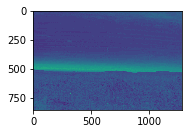

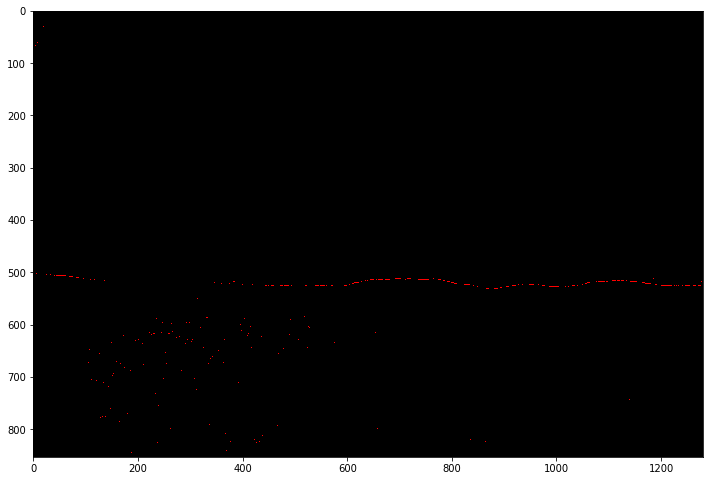

In [8]:
## Maximum Vertical Change in Intensity

# Choose a single intensity channel --> LAB format, use lightness
img_LAB = cv.cvtColor(img_BGR, cv.COLOR_BGR2LAB)
#print(img_LAB.shape)
#plt.figure(figsize = (12,36))
#plt.subplot(112),plt.imshow(img_LAB)

# Strip to just Lightness channel
img_L = img_LAB[:,:,1]
print(img_L.shape)
plt.subplot(212),plt.imshow(img_L)

# Make new mask of same dimensions to store horizon
rows,cols = img_L.shape
horizon_mask = np.zeros((rows,cols,3), np.uint8)

# Define max_diff : (row pixel number, value)
max_diff = 0
max_row = 0

# For each column of the image
for c in range(0, cols - 1):# - 5): #-- TODO: Make a window for search? --> 5 pixels vertically

    #-- Start at top and move down image
    #-- For each step 
    for r in range(0, rows-2): # to avoid stepping OOBs, comparing current to pixel below
        
        #---- Calculate the difference in lightness among pixels 
        cur_px = img_L[r, c]
        next_px = img_L[r+1, c]
        
        #l_diff = abs(cur_px - next_px) # DOESNT WORK: overflows uint8 data
        l_diff = abs(int(cur_px) - int(next_px)) # do calculation as ints to avoid this
        
        #---- If this is a maximum, save the  location
        if(l_diff > max_diff):
            max_diff = l_diff
            max_row = r

            
    #-- Mark the maximum difference in the image on the horizon mask
    horizon_mask[max_row, c, 0] = 255
    #print(max_row)
    # Reset max row and difference
    max_row = 0
    max_diff = 0
    
    
# Display the resulting marks
plt.figure(figsize = (12,36))
plt.subplot(211),plt.imshow(horizon_mask)